2025-02-24 11:06:52.043566: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8907
2025-02-24 11:06:52.228623: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 0s 404ms/step


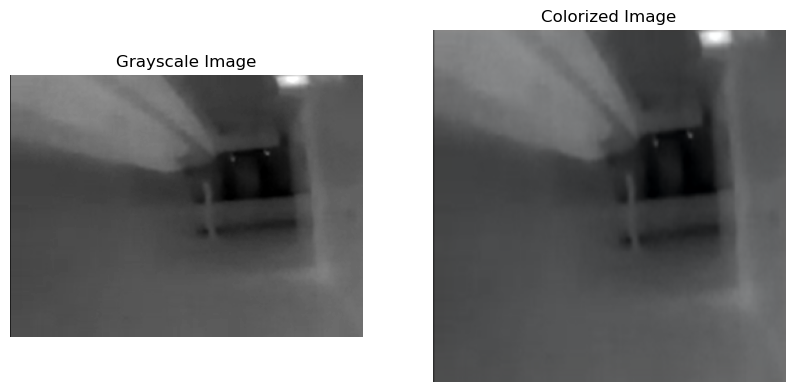

In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, concatenate, RepeatVector, Reshape
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize

# Load InceptionResNetV2 Model for Feature Extraction
inception = InceptionResNetV2(weights='imagenet', include_top=True)
inception.graph = tf.compat.v1.get_default_graph()

# Function to preprocess input image for InceptionResNetV2
def extract_features(img_rgb):
    img_resized = resize(img_rgb, (299, 299, 3), mode='constant')
    img_resized = np.expand_dims(img_resized, axis=0)
    img_resized = tf.keras.applications.inception_resnet_v2.preprocess_input(img_resized)
    return inception.predict(img_resized)

# Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)

# Feature Extractor
feature_input = Input(shape=(1000,))
fusion_output = RepeatVector(32 * 32)(feature_input)
fusion_output = Reshape((32, 32, 1000))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3)
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)

# Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

# Model Compilation
model = Model(inputs=[encoder_input, feature_input], outputs=decoder_output)
model.compile(optimizer='adam', loss='mse')

# Load and preprocess grayscale image
def process_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = resize(img, (256, 256))
    img_lab = rgb2lab(img)  # Convert to LAB color space
    img_l = img_lab[:, :, 0] / 100.0
    img_ab = img_lab[:, :, 1:] / 128.0
    img_l = np.expand_dims(img_l, axis=-1)
    return img_l, img_ab

# Predict color for grayscale image
def colorize_image(image_path):
    img_l, _ = process_image(image_path)
    img_l = np.expand_dims(img_l, axis=0)
    img_rgb = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    features = extract_features(img_rgb)
    pred_ab = model.predict([img_l, features])
    pred_ab = pred_ab * 128  # Scale back to LAB space
    img_lab_out = np.concatenate((img_l[0] * 100, pred_ab[0]), axis=-1)
    img_rgb_out = lab2rgb(img_lab_out)
    
    # Display Results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title("Grayscale Image")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_rgb_out)
    plt.title("Colorized Image")
    plt.axis("off")
    plt.show()

# Example Usage (Replace 'image.jpg' with actual path)
colorize_image("image.png")


1/1 [==============================] - 0s 65ms/step


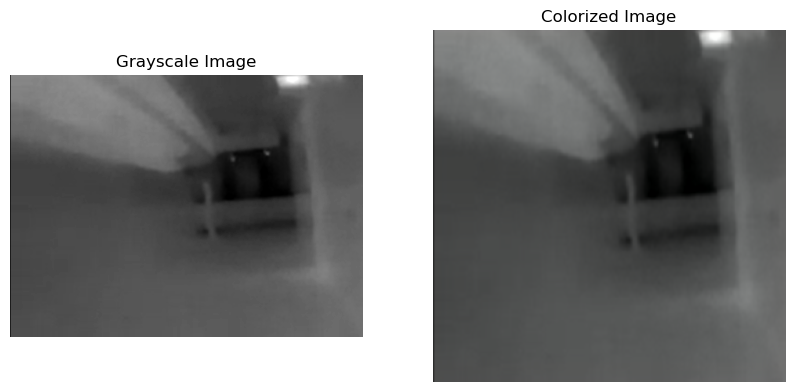

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, concatenate, RepeatVector, Reshape
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize

# Load pre-trained InceptionResNetV2 for feature extraction
inception = InceptionResNetV2(weights='imagenet', include_top=True)
inception.graph = tf.compat.v1.get_default_graph()

# Function to extract deep features
def extract_features(img_rgb):
    img_resized = resize(img_rgb, (299, 299, 3), mode='constant')
    img_resized = np.expand_dims(img_resized, axis=0)
    img_resized = tf.keras.applications.inception_resnet_v2.preprocess_input(img_resized)
    return inception.predict(img_resized)

# Define Model (Encoder-Decoder)
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)

# Feature Extractor
feature_input = Input(shape=(1000,))
fusion_output = RepeatVector(32 * 32)(feature_input)
fusion_output = Reshape((32, 32, 1000))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3)
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)

# Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

# Model Compilation
model = Model(inputs=[encoder_input, feature_input], outputs=decoder_output)
model.compile(optimizer='adam', loss='mse')

# Load and preprocess grayscale image
def process_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = resize(img, (256, 256))
    img_lab = rgb2lab(img)  # Convert to LAB color space
    img_l = img_lab[:, :, 0] / 100.0  # Normalize L channel
    img_ab = img_lab[:, :, 1:] / 128.0  # Normalize A/B channels
    img_l = np.expand_dims(img_l, axis=-1)
    return img_l, img_ab

# Predict color for grayscale image
def colorize_image(image_path):
    img_l, _ = process_image(image_path)
    img_l = np.expand_dims(img_l, axis=0)
    img_rgb = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    features = extract_features(img_rgb)
    pred_ab = model.predict([img_l, features])
    
    # Fix 1: Ensure AB channels are scaled back correctly
    pred_ab = pred_ab * 128  # Convert back to LAB range
    
    # Fix 2: Ensure LAB channels are correctly combined
    img_lab_out = np.concatenate((img_l[0] * 100, pred_ab[0]), axis=-1)  # Merge L with AB
    img_rgb_out = lab2rgb(img_lab_out)  # Convert LAB to RGB
    
    # Fix 3: Ensure output image is in correct format
    img_rgb_out = np.clip(img_rgb_out, 0, 1)  # Ensure valid pixel range
    
    # Display Results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title("Grayscale Image")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_rgb_out)
    plt.title("Colorized Image")
    plt.axis("off")
    plt.show()

# Example Usage (Replace 'image.jpg' with actual path)
colorize_image("image.png")
